# 4 Quality Control: Relatedness & Population Stratification

## 4.1 Relatedness

Another common QC check that people apply is to see whether anyone in their data set is related to each other (i.e., their genomes are far more similar than the genomes of two unrelated people). This makes sense, as most statistical methods assume independent samples and if you have, say, two sisters in the analysis, they’re not really independent. 

All humans are genetically related to each other, but the level of relatedness
varies between pairs of individuals. These differences in the levels of relatedness
need to be accounted for in GWAS, since otherwise they could bias the statistical
association between genotypes and phenotypes. 

**Cryptic relatedness** can interfere with the association analysis ([Voight et al., 2005](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1200427/)). If you have a family-based sample (e.g., parent-offspring), you do not need to remove related pairs but the statistical analysis should take family relatedness into account. However, for a population based sample we suggest to use a $\hat{\pi}$ threshold of 0.2. $\hat{\pi}$ is computed as P(IBD = 2) + 0.5 × P(IBD = 1), where P denotes probablility. $\hat{\pi}$ ranges between 0 and 1, where 0 indicates no relationship, and the higher the value the closer the relatedness.

We link the data folder to easily access it

In [1]:
ln -sf ../Data

### 4.1.1 Commands

We again use independent SNPs for our analysis. Furthermore, it is essential to check datasets you analyse for cryptic relatedness. Assuming a random population sample we are going to exclude all individuals above the $\hat{\pi}$ threshold of 0.2 in this tutorial. 

The HapMap dataset is known to contain parent-offspring relations. The following commands will visualize specifically these parent-offspring relations, using the $z$ values. $z_0$ indiciates the fraction of the genome that have no alleles IBD with another genome, and $z_1$ with 1 allele IBD. 

In [4]:
### Step 6 - Relatedness ###

# Check for relationships between individuals with a pihat > 0.2.
plink --bfile HapMap_3_r3_10 --extract indepSNP.prune.in --genome --min 0.2 --out pihat_min0.2 > /dev/null

# Set-up for a "zoomed-in" plot
awk '{ if ($8 >0.9) print $0 }' pihat_min0.2.genome > zoom_pihat.genome

After generating these files, we plot the z-values against each other:

In [5]:
# Generate a plot to assess the type of relationship.
Rscript --no-save Data/Relatedness.R > /dev/null

Warning message:
package ‘ggplot2’ was built under R version 4.1.3 
Saving 7 x 7 in image
Saving 7 x 7 in image
Warning message:
Removed 1 rows containing missing values (`geom_point()`). 
Saving 7 x 7 in image


<div>
<img src="./Images/relatedness.png" width="700"/>
</div>

*Figure 4.1: Relatedness among pairs of individuals, where PO = parent-offspring, UN = unrelated individuals*

<div>
<img src="./Images/relatedness_zoom.png" width="700"/>
</div>

*Figure 4.2: Relatedness among pairs of Parent-Offspring individuals (zoomed in on Figure 5.1)*

The generated plots show a considerable amount of related individuals in the HapMap data. However, this is expected 
since the dataset was constructed as such. Normally, family based data should be analyzed using specific family based methods. In this tutorial, for demonstrative purposes, we will treat the relatedness as cryptic relatedness 
in a random population sample.

<div>
<img src="./Images/histrelatedness.png" width="500"/>
</div>

*Figure 4.3: Histogram of measures of relatedness*

To demonstrate that the majority of the relatedness was due to parent-offspring we only 
include founders (individuals without parents in the dataset):

In [6]:
# Only include founders
plink --bfile HapMap_3_r3_10 --filter-founders --make-bed --out HapMap_3_r3_11 > /dev/null

# Now we will look again for individuals with a pihat > 0.2.
plink --bfile HapMap_3_r3_11 --extract indepSNP.prune.in --genome --min 0.2 \
--out pihat_min0.2_in_founders > /dev/null

The file `pihat_min0.2_in_founders.genome` shows that, after exclusion of all non-founders, only 1 individual pair with a $\hat{\pi}$ greater than 0.2 remains in the HapMap data. This is likely to be a full sib or DZ twin pair based on the Z values. Noteworthy, they were not given the same family identity (FID) in the HapMap data.

In [7]:
cat pihat_min0.2_in_founders.genome

   FID1     IID1   FID2     IID2 RT    EZ      Z0      Z1      Z2  PI_HAT PHE       DST     PPC   RATIO
  13291  NA07045   1454  NA12813 UN    NA  0.2572  0.5007  0.2421  0.4924   0  0.839777  1.0000  9.7022


We do not need to remove both individuals from the sample. It is sufficient to remove only one, and the one we choose should have the lowest call rate:

In [8]:
plink --bfile HapMap_3_r3_11 --missing > /dev/null

We find that individual `13291 NA07045` has the lowest call rate, so we remove this indiviual from the set:

In [9]:
echo "13291  NA07045" > 0.2_low_call_rate_pihat.txt

In [10]:
# Delete the individuals with the lowest call rate in 'related' pairs with a pihat > 0.2 
plink --bfile HapMap_3_r3_11 --remove 0.2_low_call_rate_pihat.txt --make-bed --out HapMap_3_r3_12 > /dev/null

## 4.2 Population Stratification/Ethnic Outliers

An important source of systematic bias in GWAS is population stratification. This is when subpopulations have formed, leading to systematic differences in allele frequencies. It has been shown that even subtle degrees of population stratification within a single ethnic population can exist ([Abdellaoui et al., 2013](https://www.nature.com/articles/ejhg201348)). Therefore, testing and controlling for the presence of population stratification is an essential QC step.

There are several methods to correct for population stratification ([Price, Zaitlen, Reich, & Patterson, 2010](https://www.nature.com/articles/nrg2813)). In this tutorial, we illustrate a method that is incorporated in PLINK: the **multidimensional scaling (MDS)** approach. This method calculates the genome-wide average proportion of alleles shared between any pair of individuals within the sample to generate quantitative indices (components) of the genetic variation for each individual. The individual component scores can be plotted to explore whether there are groups of individuals that are genetically more similar to each other than expected. For example, in a genetic study including subjects from Asia and Europe, MDS analysis would reveal that Asians are genetically more similar to each other than to Europeans. To investigate for which individuals the generated component scores deviate from the samples' target population, plotting of the scores of the sample under investigation and a population of known ethnic structure (e.g., HapMap/1KG data) is helpful: This step is called **anchoring** ([Rietveld et al. 2013](https://www.science.org/doi/full/10.1126/science.1235488?casa_token=y47eW3sLDl0AAAAA%3A15LXufxrmwyVXm_KwLRLrY-6HdRRDzqUnksSyi6SGW1ukW8HlBtSG5AeSgKOnkauqwuoM_KnkAHojX4)). This enables the researcher to obtain ethnic information on their sample and to determine possible ethnic outliers. 

Individuals who are outliers based on the MDS analysis should be removed from further analyses. After the exclusion of these individuals, a new MDS analysis must be conducted, and its main components need to be used as covariates in the association tests in order to correct for any remaining population stratification within the population. How many components need to be included depends on the population structure and the sample size, but the inclusion of up to 10 components is generally accepted within the psychiatric genetics community, for example.

### 4.7.1 Commands

First the 1000 Genomes genetic data for our HapMap data to be anchored against needs to be downloaded. You can do so with the following command:

In [11]:
# DO NOT RUN

## Download 1000 Genomes data ##
# This file from the 1000 Genomes contains genetic data of 629 individuals from different ethnic backgrounds.
# Note, this file is quite large (>60 gigabyte). 

# wget ftp://ftp-trace.ncbi.nih.gov/1000genomes/ftp/release/20100804/ALL.2of4intersection.20100804.genotypes.vcf.gz --output -

and can then be converted from the .vcf file (Variant Call Format) into PLINK format:

In [12]:
#plink --vcf ALL.2of4intersection.20100804.genotypes.vcf.gz --make-bed --out ALL.2of4intersection.20100804.genotypes

However, as stated above, the 1000 Genomes data is rather large, and so to save time, we have supplied the `.bed`, `.bim`and `.fam` files in the `Data` folder.

We unzip the file and see how many samples we have:

In [13]:
unzip Data/1000genomes.zip
wc -l 1000genomes.genotypesA.fam

Archive:  Data/1000genomes.zip
  inflating: 1000genomes.genotypesA.bed  
  inflating: 1000genomes.genotypesA.bim  
  inflating: 1000genomes.genotypesA.fam  
  inflating: 1000genomes.genotypesA.log  
  inflating: 1000genomes.genotypesA.nosex  
37 1000genomes.genotypesA.fam


One should note that the file `1000genomes.genotypes.bim` contains SNPs without an rs-identifier (or Reference SNP cluster ID): 

In [14]:
cat 1000genomes.genotypesA.bim | head -n 10

1	rs112750067	0	10327	C	T
1	.	0	11508	A	G
1	.	0	12783	G	A
1	.	0	13116	G	T
1	.	0	14933	A	G
1	.	0	15211	T	G
1	.	0	15274	A	T
1	.	0	15820	T	G
1	.	0	16378	T	C
1	.	0	28376	G	A
cat: write error: Broken pipe


The missing rs-identifiers in the 1000 Genomes data are not a problem for this tutorial. However, for good practice, we will assign unique indentifiers to the SNPs with a missing rs-identifier (i.e., the SNPs with "."):

In [15]:
plink --bfile 1000genomes.genotypesA --set-missing-var-ids @:#[b37]\$1,\$2 --make-bed --out 1000genomes.genotypesA_no_missing_IDs

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to 1000genomes.genotypesA_no_missing_IDs.log.
Options in effect:
  --bfile 1000genomes.genotypesA
  --make-bed
  --out 1000genomes.genotypesA_no_missing_IDs
  --set-missing-var-ids @:#[b37]$1,$2

385583 MB RAM detected; reserving 192791 MB for main workspace.
9688241 variants loaded from .bim file.
3944559 missing IDs set.
37 people (0 males, 0 females, 37 ambiguous) loaded from .fam.
Ambiguous sex IDs written to 1000genomes.genotypesA_no_missing_IDs.nosex .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 37 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.

In [16]:
cat 1000genomes.genotypesA_no_missing_IDs.bim | head -n 10

1	rs112750067	0	10327	C	T
1	1:11508[b37]A,G	0	11508	A	G
1	1:12783[b37]A,G	0	12783	G	A
1	1:13116[b37]G,T	0	13116	G	T
1	1:14933[b37]A,G	0	14933	A	G
1	1:15211[b37]G,T	0	15211	T	G
1	1:15274[b37]A,T	0	15274	A	T
1	1:15820[b37]G,T	0	15820	T	G
1	1:16378[b37]C,T	0	16378	T	C
1	1:28376[b37]A,G	0	28376	G	A
cat: write error: Broken pipe


Before we merge the 1000 Genomes and HapMap datasets, we first need to apply some QC on our 1000 Genomes data. As before, we consider missingness, sex discrepency, and minor allele frequency: 

In [17]:
## QC on 1000 Genomes data.
# Remove variants based on missing genotype data.
plink --bfile 1000genomes.genotypesA_no_missing_IDs --geno 0.2 --allow-no-sex --make-bed --out 1kG_MDS > /dev/null

# Remove individuals based on missing genotype data.
plink --bfile 1kG_MDS --mind 0.2 --allow-no-sex --make-bed --out 1kG_MDS2 > /dev/null

# Remove variants based on missing genotype data.
plink --bfile 1kG_MDS2 --geno 0.02 --allow-no-sex --make-bed --out 1kG_MDS3 > /dev/null

# Remove individuals based on missing genotype data.
plink --bfile 1kG_MDS3 --mind 0.02 --allow-no-sex --make-bed --out 1kG_MDS4 > /dev/null

# Remove variants based on MAF.
plink --bfile 1kG_MDS4 --maf 0.05 --allow-no-sex --make-bed --out 1kG_MDS5 > /dev/null

We want to only consider SNPs that both datasets have in common. So for each dataset, we extract those that are present in the other. Furthermore, they must have the same build so that they can be merged later:

In [18]:
# Extract the variants present in HapMap dataset from the 1000 genomes dataset.
awk '{print$2}' HapMap_3_r3_12.bim > HapMap_SNPs.txt
plink --bfile 1kG_MDS5 --extract HapMap_SNPs.txt --make-bed --out 1kG_MDS6 > /dev/null

# Extract the variants present in 1000 Genomes dataset from the HapMap dataset.
awk '{print$2}' 1kG_MDS6.bim > 1kG_MDS6_SNPs.txt
plink --bfile HapMap_3_r3_12 --extract 1kG_MDS6_SNPs.txt --recode --make-bed --out HapMap_MDS > /dev/null
# The datasets now contain the exact same variants.

## The datasets must have the same build. Change the build 1000 Genomes data build.
awk '{print$2,$4}' HapMap_MDS.map > buildhapmap.txt
# buildhapmap.txt contains one SNP-id and physical position per line.

plink --bfile 1kG_MDS6 --update-map buildhapmap.txt --make-bed --out 1kG_MDS7 > /dev/null
# 1kG_MDS7 and HapMap_MDS now have the same build.

Now we merge the HapMap and 1000 Genomes data sets.

Prior to merging 1000 Genomes data with the HapMap data we want to make sure that the files are mergeable. For this we conduct 3 steps:

1) Make sure the reference genome is similar in the HapMap and the 1000 Genomes Project datasets.  
2) Resolve strand issues.  
3) Remove the SNPs which after the previous two steps still differ between datasets.  

The following steps are maybe quite technical in terms of commands, but we simply compare the two data sets and make sure they correspond:

In [19]:
# 1) set reference genome 
awk '{print$2,$5}' 1kG_MDS7.bim > 1kg_ref-list.txt
plink --bfile HapMap_MDS --reference-allele 1kg_ref-list.txt --make-bed --out HapMap-adj > /dev/null
# The 1kG_MDS7 and the HapMap-adj have the same reference genome for all SNPs.
# This command will generate some warnings for impossible A1 allele assignment.

# 2) Resolve strand issues.
# Check for potential strand issues.
awk '{print$2,$5,$6}' 1kG_MDS7.bim > 1kGMDS7_tmp
awk '{print$2,$5,$6}' HapMap-adj.bim > HapMap-adj_tmp
sort 1kGMDS7_tmp HapMap-adj_tmp |uniq -u > all_differences.txt
# 1624 differences between the files, some of these might be due to strand issues.

## Flip SNPs for resolving strand issues.
# Print SNP-identifier and remove duplicates.
awk '{print$1}' all_differences.txt | sort -u > flip_list.txt
# Generates a file of 812 SNPs. These are the non-corresponding SNPs between the two files. 
# Flip the 812 non-corresponding SNPs. 
plink --bfile HapMap-adj --flip flip_list.txt --reference-allele 1kg_ref-list.txt --make-bed --out corrected_hapmap > /dev/null

# Check for SNPs which are still problematic after they have been flipped.
awk '{print$2,$5,$6}' corrected_hapmap.bim > corrected_hapmap_tmp
sort 1kGMDS7_tmp corrected_hapmap_tmp |uniq -u  > uncorresponding_SNPs.txt
# This file demonstrates that there are 84 differences between the files.

# 3) Remove problematic SNPs from HapMap and 1000 Genomes.
awk '{print$1}' uncorresponding_SNPs.txt | sort -u > SNPs_for_exlusion.txt
# The command above generates a list of the 42 SNPs which caused the 84 differences between the HapMap and the 1000 Genomes data sets after flipping and setting of the reference genome.

# Remove the 42 problematic SNPs from both datasets.
plink --bfile corrected_hapmap --exclude SNPs_for_exlusion.txt --make-bed --out HapMap_MDS2 > /dev/null
plink --bfile 1kG_MDS7 --exclude SNPs_for_exlusion.txt --make-bed --out 1kG_MDS8 > /dev/null

# Merge HapMap with 1000 Genomes Data.
plink --bfile HapMap_MDS2 --bmerge 1kG_MDS8.bed 1kG_MDS8.bim 1kG_MDS8.fam --allow-no-sex --make-bed --out MDS_merge2 > /dev/null

# Note, we are fully aware of the sample overlap between the HapMap and 1000 Genomes datasets. 
# However, for the purpose of this tutorial this is not important.

We are now ready to perform MDS, which we do using the set of pruned SNPs:

In [20]:
## Perform MDS on HapMap-CEU data anchored by 1000 Genomes data.
# Using a set of pruned SNPs
plink --bfile MDS_merge2 --extract indepSNP.prune.in --genome --out MDS_merge2
plink --bfile MDS_merge2 --read-genome MDS_merge2.genome --cluster --mds-plot 10 --out MDS_merge2

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to MDS_merge2.log.
Options in effect:
  --bfile MDS_merge2
  --extract indepSNP.prune.in
  --genome
  --out MDS_merge2

385583 MB RAM detected; reserving 192791 MB for main workspace.
376368 variants loaded from .bim file.
146 people (55 males, 54 females, 37 ambiguous) loaded from .fam.
Ambiguous sex IDs written to MDS_merge2.nosex .
109 phenotype values loaded from .fam.
--extract: 35215 variants remaining.
Using up to 63 threads (change this with --threads).
Before main variant filters, 146 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.99851.
35215 variants and 146 people pass filters an

In [21]:
wget ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20100804/20100804.ALL.panel

--2023-05-09 13:14:11--  ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20100804/20100804.ALL.panel
           => ‘20100804.ALL.panel’
Resolving ftp.1000genomes.ebi.ac.uk (ftp.1000genomes.ebi.ac.uk)... 193.62.193.140
Connecting to ftp.1000genomes.ebi.ac.uk (ftp.1000genomes.ebi.ac.uk)|193.62.193.140|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /vol1/ftp/release/20100804 ... done.
==> SIZE 20100804.ALL.panel ... 13499
==> PASV ... done.    ==> RETR 20100804.ALL.panel ... done.
Length: 13499 (13K) (unauthoritative)

20100804.ALL.panel  100%[===================>]  13.18K  --.-KB/s    in 0s      

2023-05-09 13:14:11 (134 MB/s) - ‘20100804.ALL.panel’ saved [13499]



In [22]:
### MDS-plot

# If you have downloaded the entire 1000genomes dataset from above, you will need to 
# download the file with population information of the 1000 genomes dataset.
#wget ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20100804/20100804.ALL.panel
# The file 20100804.ALL.panel contains population codes of the individuals of 1000 genomes.
# But we have again provided the thinned version for this exercise

# Convert population codes into superpopulation codes (i.e., AFR,AMR,ASN, and EUR).
awk '{print$1,$1,$2}' 20100804.ALL.panel > race_1kG.txt
sed 's/JPT/ASN/g' race_1kG.txt>race_1kG2.txt
sed 's/ASW/AFR/g' race_1kG2.txt>race_1kG3.txt
sed 's/CEU/EUR/g' race_1kG3.txt>race_1kG4.txt
sed 's/CHB/ASN/g' race_1kG4.txt>race_1kG5.txt
sed 's/CHD/ASN/g' race_1kG5.txt>race_1kG6.txt
sed 's/YRI/AFR/g' race_1kG6.txt>race_1kG7.txt
sed 's/LWK/AFR/g' race_1kG7.txt>race_1kG8.txt
sed 's/TSI/EUR/g' race_1kG8.txt>race_1kG9.txt
sed 's/MXL/AMR/g' race_1kG9.txt>race_1kG10.txt
sed 's/GBR/EUR/g' race_1kG10.txt>race_1kG11.txt
sed 's/FIN/EUR/g' race_1kG11.txt>race_1kG12.txt
sed 's/CHS/ASN/g' race_1kG12.txt>race_1kG13.txt
sed 's/PUR/AMR/g' race_1kG13.txt>race_1kG14.txt

# Create a racefile of your own data.
awk '{print$1,$2,"OWN"}' HapMap_MDS.fam > racefile_own.txt

# Concatenate racefiles.
cat <(echo "FID IID race") race_1kG14.txt racefile_own.txt > racefile.txt

# Generate population stratification plot.
Rscript Data/MDS_merged.R > /dev/null

Warning message:
package ‘ggplot2’ was built under R version 4.1.3 
Saving 7 x 7 in image


This produces the following MDS plot:

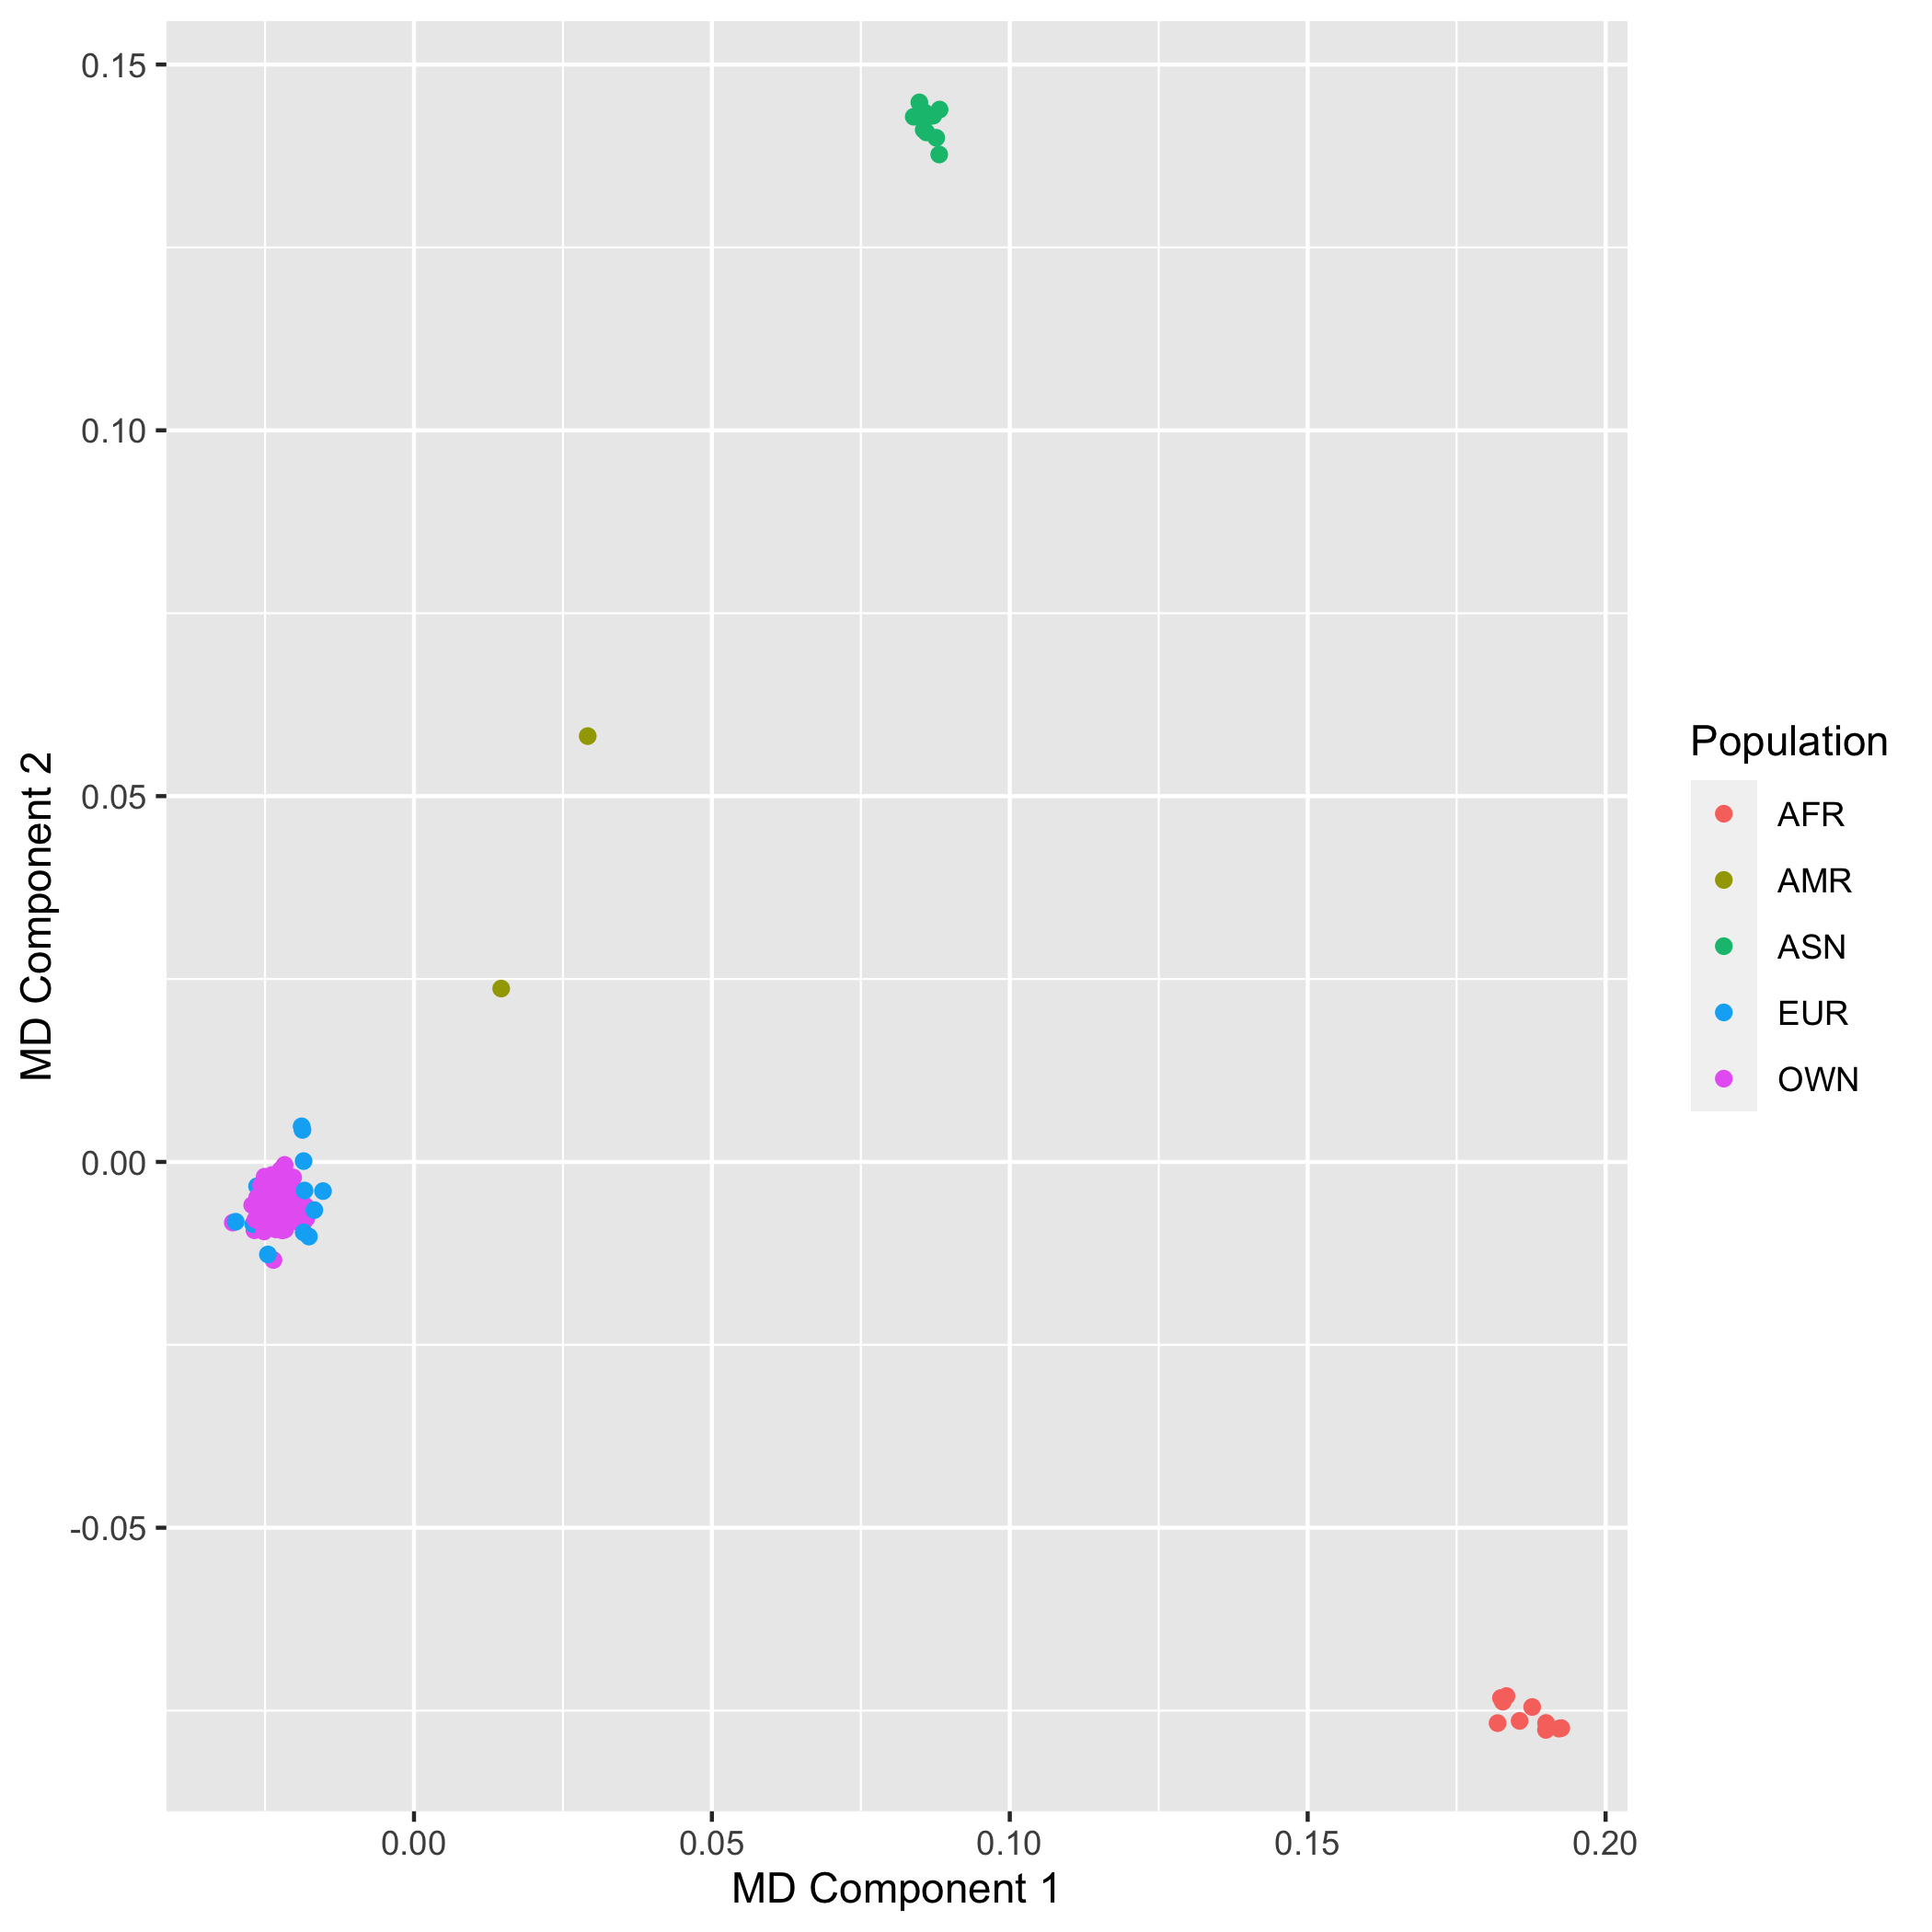

This plot demonstrates that our data falls within the European group of the 1000 genomes data. Therefore, we do not have to remove subjects. 

For educational purposes however, we give scripts below to filter out population stratification outliers. Please execute the script below in order to generate the appropriate files for the next tutorial.

In [23]:
## Exclude ethnic outliers.
# Select individuals in HapMap data below cut-off thresholds. 
# The cut-off levels are not fixed thresholds but have to be determined based on the visualization 
# of the first two dimensions. To exclude ethnic outliers, the thresholds need to be set around the 
# cluster of population of interest.
awk '{ if ($4 <0 && $5 <0.02) print $1,$2 }' MDS_merge2.mds > EUR_MDS_merge2

# Extract these individuals in HapMap data.
plink --bfile HapMap_3_r3_12 --keep EUR_MDS_merge2 --make-bed --out HapMap_3_r3_13 > /dev/null
# Note, since our HapMap data did include any ethnic outliers, no individuls were removed at this step. 
# However, if our data would have included individuals outside of the thresholds we set, then these 
# individuals would have been removed.

## Create covariates based on MDS.
# Perform an MDS ONLY on HapMap data without ethnic outliers. 
# The values of the 10 MDS dimensions are subsequently used as covariates in the association 
# analysis in the third tutorial.
plink --bfile HapMap_3_r3_13 --extract indepSNP.prune.in --genome --out HapMap_3_r3_13 > /dev/null
plink --bfile HapMap_3_r3_13 --read-genome HapMap_3_r3_13.genome --cluster --mds-plot 10 --out HapMap_3_r3_13_mds > /dev/null

# Change the format of the .mds file into a plink covariate file.
awk '{print$1, $2, $4, $5, $6, $7, $8, $9, $10, $11, $12, $13}' HapMap_3_r3_13_mds.mds > covar_mds.txt

The values in `covar_mds.txt` will be used as covariates, to adjust for remaining population stratification, in the third tutorial where we will perform a genome-wide association analysis.

## Summary 

Below is a cheat sheet of our new methods of QC. Again, it is important to remember that each method of QC should be justified, which will depend on what the nature of the feature is you are trying to analyse.


| Step                         | Command                | Function                                                                                                                                                                                                            | Thresholds and explanation                                                                                                                                                                                                                                                                                                                                                                                              |
|------------------------------|------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 6: Relatedness               | --genome               | Calculates identity by descent (IBD) of all sample pairs.                                                                                                                                                           | Use independent SNPs ( pruning) for this analysis and limit it to autosomal chromosomes only.                                                                                                                                                                                                                                                                                                                           |
|                              | --min                  | Sets threshold and creates a list of individuals with relatedness above  the chosen threshold. Meaning that subjects who are related at, for  example, pi‐hat >0.2 (i.e., second degree relatives) can be detected. | Cryptic relatedness can interfere with the association analysis. If you  have a family‐based sample (e.g., parent‐offspring), you do not need to  remove related pairs but the statistical analysis should take family  relatedness into account. However, for a population based sample we  suggest to use a pi‐hat threshold of 0.2, which in line with the  literature (Anderson et al.,  2010 ; Guo et al.,  2014). |
| 7: Population Stratification | --genome               | Calculates identity by descent (IBD) of all sample pairs.                                                                                                                                                           | Use independent SNPs ( pruning) for this analysis and limit it to autosomal chromosomes only.                                                                                                                                                                                                                                                                                                                           |
|                              | --cluster --mds-plot k | Produces a  k‐dimensional representation of any substructure in the data, based on IBS.                                                                                                                             | K is the number of dimensions, which needs to be defined  (typically 10). This is an important step of the QC that consists of  multiple proceedings but for reasons of completeness we briefly refer to  this step in the table. This step will be described in more detail in  section “controlling for population stratification.”                                                                                   |

***

You have now succesfully controlled your data for population stratification!

In the next notebook on **Association Testing**, you need the following files:
- `HapMap_3_r3_13` (the bfile, i.e., `HapMap_3_r3_13.bed`, `HapMap_3_r3_13.bim`, and `HapMap_3_r3_13.fam`)
- `covar_mds.txt`